# Đọc dữ liệu

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR,VARMAX,ARIMA
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import r2_score
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import AutoARIMA,auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras.layers import LeakyReLU
from sklearn.linear_model import SGDRegressor

In [2]:
data = pd.read_csv("sea.csv")
data['Nam'] = data['Nam'].astype('str') + "-12-31"
data = data.set_index("Nam")
data.index = pd.DatetimeIndex(data.index,freq = 'A-DEC')
data.head()


,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
Nam,,,,
1995-12-31,108.2,453.6,95700.0,1584.4
1996-12-31,107.4,498.7,97700.0,1701.0
1997-12-31,101.7,504.1,71500.0,1730.4
1998-12-31,103.0,524.5,71799.0,1782.0
1999-12-31,112.6,524.6,73397.0,2006.8


# MISSING

Text(0.5, 6.79999999999999, 'Percent')

<Figure size 720x432 with 0 Axes>

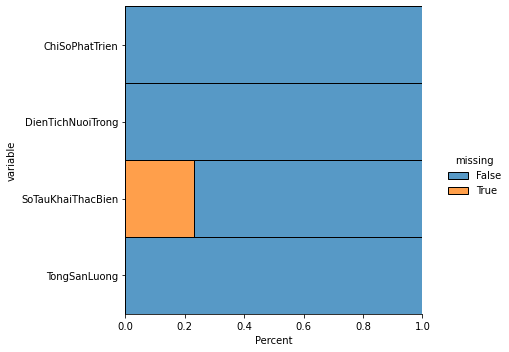

In [3]:
plt.figure(figsize=(10,6))
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)
plt.xlabel("Percent")

In [4]:
data.interpolate(method = 'time',inplace = True,axis = 0,limit_direction = 'forward')

In [5]:
data

,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
Nam,,,,
1995-12-31,108.2,453.6,95700.000000,1584.4
1996-12-31,107.4,498.7,97700.000000,1701.0
1997-12-31,101.7,504.1,71500.000000,1730.4
1998-12-31,103.0,524.5,71799.000000,1782.0
1999-12-31,112.6,524.6,73397.000000,2006.8
2000-12-31,112.1,641.9,79768.000000,2250.9
2001-12-31,108.2,755.2,78978.000000,2435.1
2002-12-31,108.7,797.7,81800.000000,2647.9
2003-12-31,108.0,867.6,83122.000000,2859.8


In [6]:
data.isna().sum()

ChiSoPhatTrien       0
DienTichNuoiTrong    0
SoTauKhaiThacBien    0
TongSanLuong         0
dtype: int64

Text(0.5, 1.0, 'TongSanLuong')

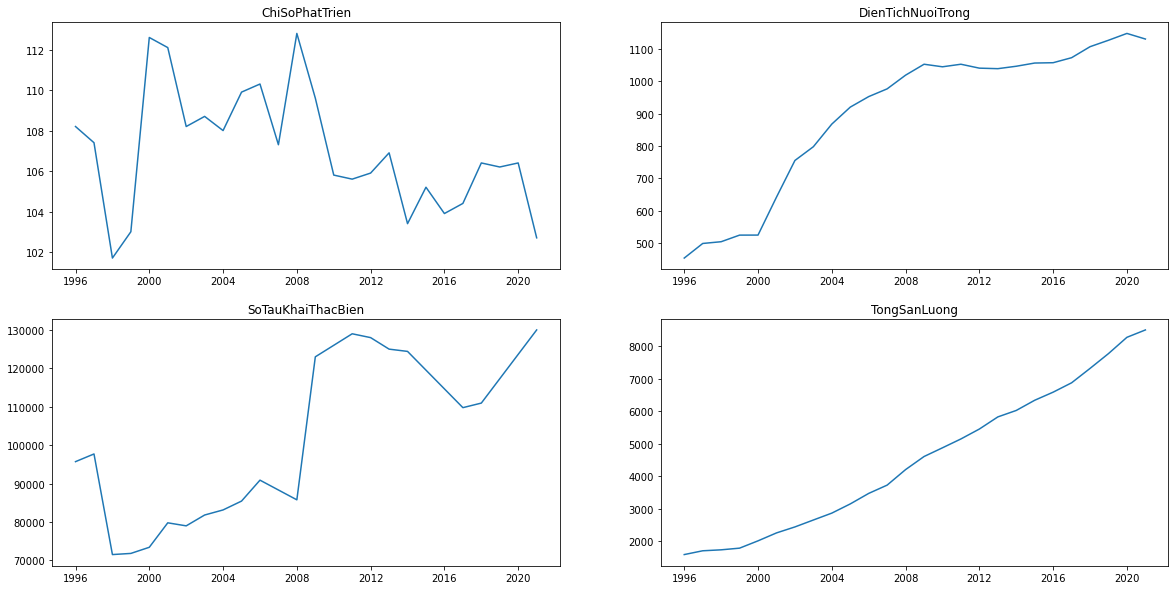

In [7]:
plt.rcParams.update({"figure.figsize":(20,10)})

fig,ax = plt.subplots(2,2)
ax[0][0].plot(data.index,data['ChiSoPhatTrien'])
ax[0][0].set_title("ChiSoPhatTrien")
ax[0][1].plot(data.index,data['DienTichNuoiTrong'])
ax[0][1].set_title("DienTichNuoiTrong")

ax[1][0].plot(data.index,data['SoTauKhaiThacBien'])
ax[1][0].set_title("SoTauKhaiThacBien")

ax[1][1].plot(data.index,data['TongSanLuong'])
ax[1][1].set_title("TongSanLuong")


# Linear Regression

## Ảnh hưởng giữa các biến trong mô hình hồi quy

In [8]:
data_linear = data.reset_index().copy()
data_linear['Nam'] = data_linear['Nam'].apply(lambda x: x.year)
data_linear.head()

,Nam,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
0,1995,108.2,453.6,95700.0,1584.4
1,1996,107.4,498.7,97700.0,1701.0
2,1997,101.7,504.1,71500.0,1730.4
3,1998,103.0,524.5,71799.0,1782.0
4,1999,112.6,524.6,73397.0,2006.8


<AxesSubplot:>

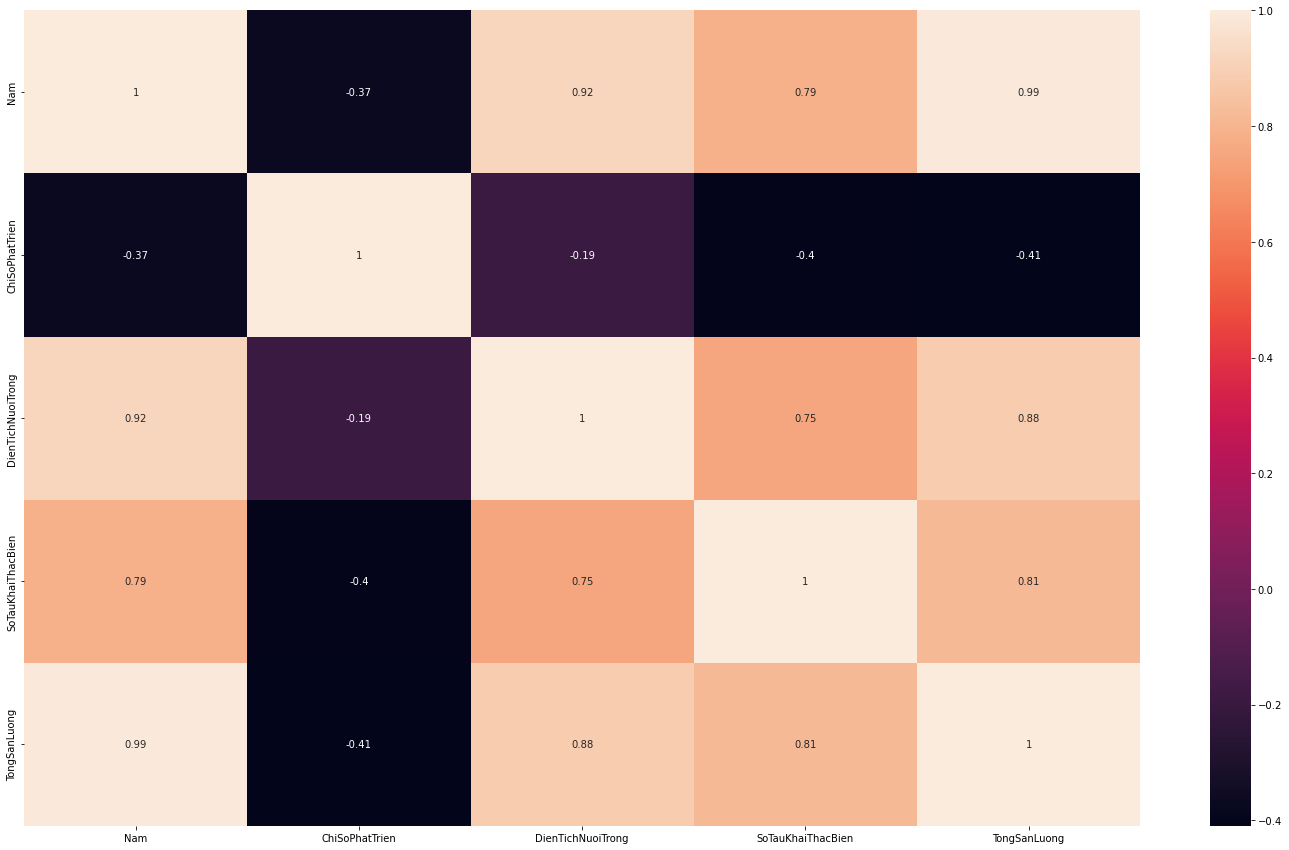

In [9]:
plt.rcParams.update({"figure.figsize":(25,15)})
sns.heatmap(data_linear.corr(),annot = True)

In [10]:
train,test = data_linear.iloc[:-10,:],data_linear.iloc[-10:,:]

In [11]:
train.head()

,Nam,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
0,1995,108.2,453.6,95700.0,1584.4
1,1996,107.4,498.7,97700.0,1701.0
2,1997,101.7,504.1,71500.0,1730.4
3,1998,103.0,524.5,71799.0,1782.0
4,1999,112.6,524.6,73397.0,2006.8


In [12]:
x_train,y_train = train.values[:,:-1],train.values[:,-1]
x_test,y_test = test.values[:,:-1],test.values[:,-1]


### Mô hình hồi quy không sử dụng yếu tố Nam

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg_without_Nam = LinearRegression()
lin_reg_without_Nam.fit(x_train[:,1:],y_train)


LinearRegression()

In [14]:
lin_reg_without_Nam.coef_,lin_reg_without_Nam.intercept_

(array([-7.25641716,  4.01540395,  0.0198855 ]), -1181.647899997788)

y = -7.25x1 + 4.0154x2+ 0.0199x3 - 1181.648

In [15]:
lin_pred_without_Nam = lin_reg_without_Nam.predict(x_test[:,1:])

In [16]:
rmse_without_Nam = rmse(lin_pred_without_Nam,test['TongSanLuong'])
r2_without_Nam = r2_score(test['TongSanLuong'],lin_pred_without_Nam)
mae_without_Nam = mean_absolute_error(lin_pred_without_Nam,test['TongSanLuong'])


In [17]:
idx = pd.date_range('2011-12-31', periods=10, freq='Y')
df_forecast_lin_without_Nam=pd.DataFrame(data=lin_pred_without_Nam, index=idx, columns=['TongSanLuong'])


In [18]:
df_forecast_lin_without_Nam

,TongSanLuong
2011-12-31,4773.269424
2012-12-31,4699.931859
2013-12-31,4743.732288
2014-12-31,4673.410932
2015-12-31,4589.847374
2016-12-31,4551.179835
2017-12-31,4696.814710
2018-12-31,4904.330249
2019-12-31,5113.761706
2020-12-31,5197.647316


Text(0, 0.5, 'TongSanLuong')

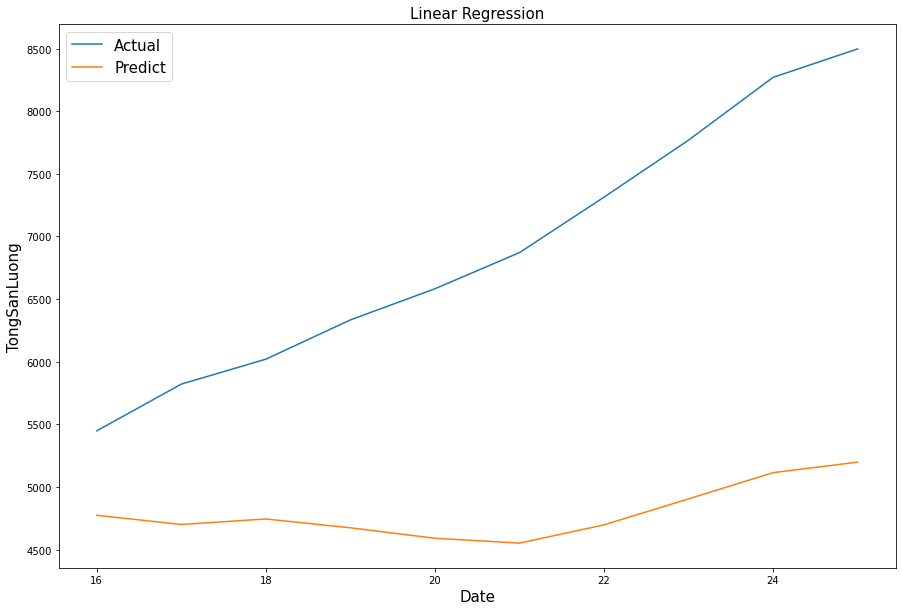

In [19]:
plt.figure(figsize = (15,10))
plt.plot(test.index,test['TongSanLuong'],label = "Actual")
plt.plot(test.index,df_forecast_lin_without_Nam['TongSanLuong'],label = "Predict")
plt.legend(fontsize = 15)
plt.title("Linear Regression",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### Mô hình hồi quy chỉ sử dụng yếu tố Nam

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg_only_Nam = LinearRegression()
lin_reg_only_Nam.fit(x_train[:,0].reshape(-1,1),y_train)


LinearRegression()

In [21]:
lin_reg_only_Nam.coef_,lin_reg_only_Nam.intercept_

(array([247.55323529]), -492716.3536764703)

y = 247.553x1 - 492716.353

In [22]:
lin_pred_only_Nam = lin_reg_only_Nam.predict(x_test[:,0].reshape(-1,1))


In [23]:
rmse_only_Nam = rmse(lin_pred_only_Nam,test['TongSanLuong'])
r2_only_Nam = r2_score(test['TongSanLuong'],lin_pred_only_Nam)
mae_only_Nam = mean_absolute_error(lin_pred_only_Nam,test['TongSanLuong'])


In [24]:
idx = pd.date_range('2011-12-31', periods=10, freq='Y')
df_forecast_only_Nam=pd.DataFrame(data=lin_pred_only_Nam, index=idx, columns=['TongSanLuong'])

Text(0, 0.5, 'TongSanLuong')

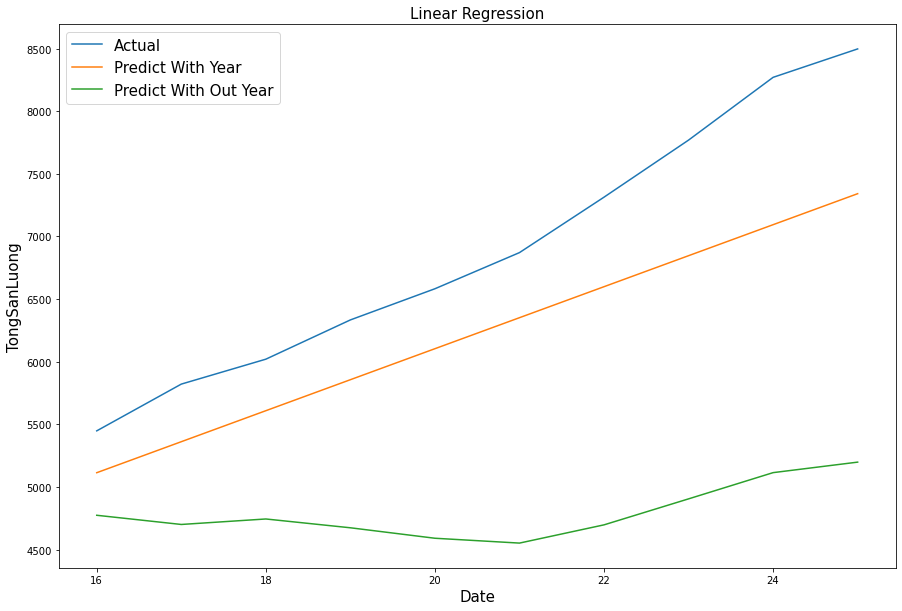

In [25]:
plt.figure(figsize = (15,10))
plt.plot(test.index,test['TongSanLuong'],label = "Actual")
plt.plot(test.index,df_forecast_only_Nam['TongSanLuong'],label = "Predict With Year")
plt.plot(test.index,df_forecast_lin_without_Nam['TongSanLuong'],label = "Predict With Out Year")

plt.legend(fontsize = 15)
plt.title("Linear Regression",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### Mô hình hồi quy sử dụng thêm yếu tố Nam

In [26]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)

LinearRegression()

In [27]:
1.36337875e-02

0.0136337875

In [28]:
lin_reg.coef_,lin_reg.intercept_

(array([ 2.37763432e+02, -7.29011385e-01, -5.34283382e-01,  1.36337875e-02]),
 -473859.0355467673)

In [29]:
lin_pred = lin_reg.predict(x_test)

In [30]:
rmse_all = rmse(lin_pred,test['TongSanLuong'])
r2_all = r2_score(test['TongSanLuong'],lin_pred)
mae_all = mean_absolute_error(lin_pred,test['TongSanLuong'])

In [31]:
mean_absolute_percentage_error(lin_pred,test['TongSanLuong'])

0.08287739694632529

In [32]:
idx = pd.date_range('2011-12-31', periods=10, freq='Y')
df_forecast_lin=pd.DataFrame(data=lin_pred, index=idx, columns=['TongSanLuong'])


Text(0, 0.5, 'TongSanLuong')

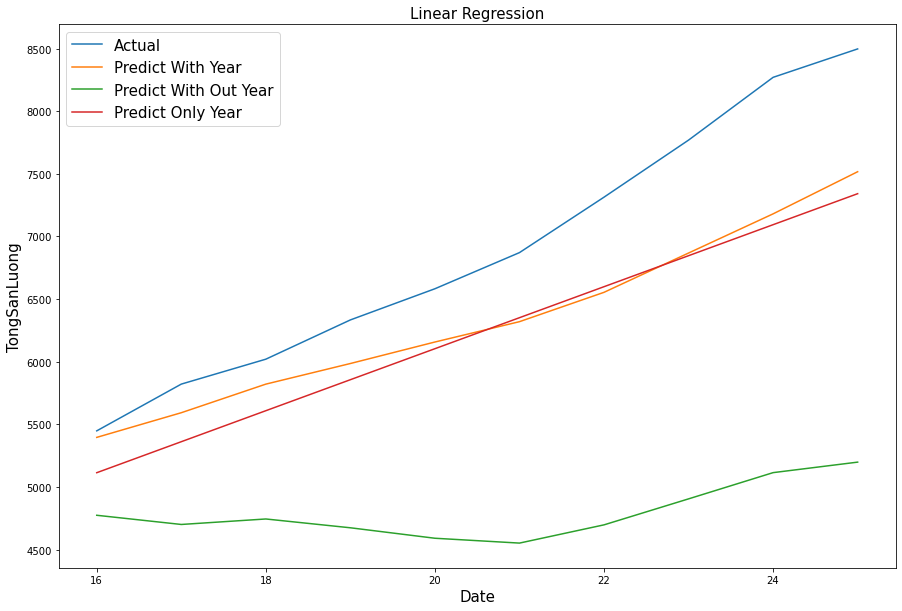

In [33]:
plt.figure(figsize = (15,10))
plt.plot(test.index,test['TongSanLuong'],label = "Actual")
plt.plot(test.index,df_forecast_lin['TongSanLuong'],label = "Predict With Year")
plt.plot(test.index,df_forecast_lin_without_Nam['TongSanLuong'],label = "Predict With Out Year")
plt.plot(test.index,df_forecast_only_Nam['TongSanLuong'],label = "Predict Only Year")

plt.legend(fontsize = 15)
plt.title("Linear Regression",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

Qua 3 đồ thị trên ta thấy yếu tố Nam ảnh hưởng mạnh mẽ tới chất lượng của mô hình, mô hình đạt kết quả cao nhất khi kết hợp tất cả các thuộc tính

In [34]:
df_rmse = pd.DataFrame({"RMSE":[rmse_only_Nam,rmse_without_Nam,rmse_all],"R2":[r2_only_Nam,r2_without_Nam,r2_all],"MAE":[mae_only_Nam,mae_without_Nam,mae_all]},index = ["Only Nam","Without Nam","All"])

In [35]:
df_rmse

,RMSE,R2,MAE
Only Nam,728.238631,0.460343,665.177941
Without Nam,2265.974092,-4.224929,2097.977431
All,651.228579,0.568444,553.690403


Text(0, 0.5, 'RMSE')

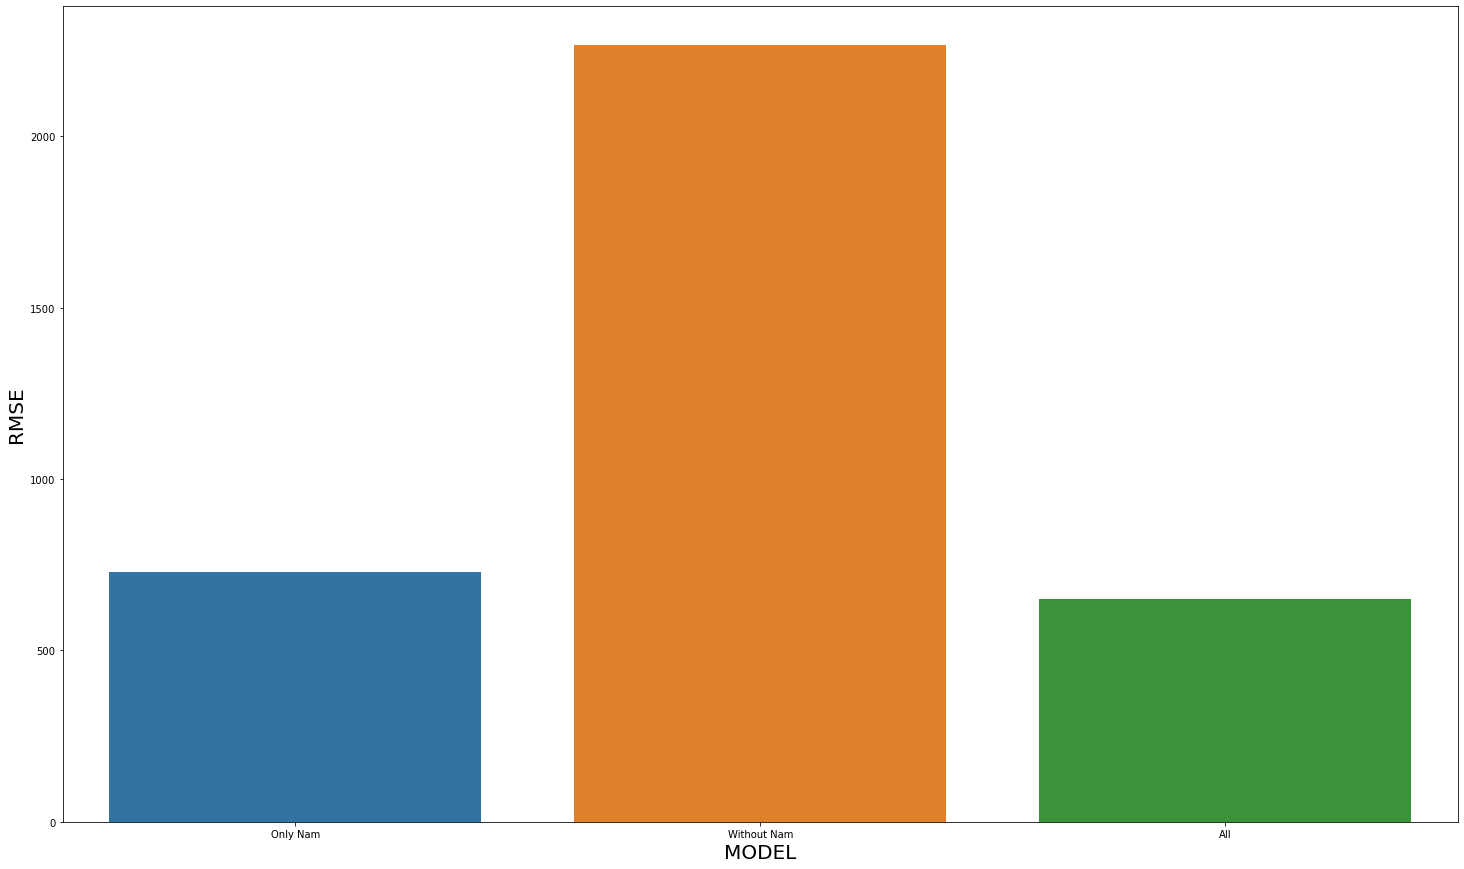

In [36]:
sns.barplot(data = df_rmse.reset_index(),x = 'index',y='RMSE')
plt.xlabel("MODEL",fontsize = 20)
plt.ylabel("RMSE",fontsize = 20)

# Kiểm định 

## ADF_TEST

In [37]:
def adf_test(data,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    for atr in list(data):
        result = adfuller(data[atr].dropna(),autolag='AIC') # .dropna() handles differenced data
        labels = ['ADF test statistic','p-value','# lags used','# observations']
        out = pd.Series(result[0:4],index=labels)
        # for key,val in result[4].items():
        #     out[f'critical value ({key})']=val
        #     print(out.to_string())  # .to_string() removes the line "dtype: float64"
        if result[1] <= 0.05:
            print(atr + ": stationary, p-value = " + str(result[1])+ ", ADF:" + str(result[0]))
        else:
            print(atr + ": non-stationary, p-value = " +  str(result[1])+ ", ADF:" + str(result[0]))


In [38]:
adf_test(data)

Augmented Dickey-Fuller Test: 
ChiSoPhatTrien: non-stationary, p-value = 0.0556504288875797, ADF:-2.818710367942458
DienTichNuoiTrong: non-stationary, p-value = 0.09086142587879448, ADF:-2.6104264363108487
SoTauKhaiThacBien: non-stationary, p-value = 0.8173992864669152, ADF:-0.8058444058139393
TongSanLuong: non-stationary, p-value = 1.0, ADF:3.631552418832209


Biến đổi sang chuỗi dừng bằng cách lấy sai phân bậc 2


In [39]:
data_diff = data.diff()
data_diff = data_diff.iloc[1:,:]
data_first_diff = data_diff.loc["2015-12-31","TongSanLuong"]

data_diff['DienTichNuoiTrong']=data_diff['DienTichNuoiTrong'].apply(lambda x:np.cbrt(x))
data_diff['TongSanLuong']=data_diff['TongSanLuong'].diff()
data_diff = data_diff.iloc[1:,:]


In [40]:
data_diff.head()

,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
Nam,,,,
1997-12-31,-5.7,1.754411,-26200.0,-87.2
1998-12-31,1.3,2.732394,299.0,22.2
1999-12-31,9.6,0.464159,1598.0,173.2
2000-12-31,-0.5,4.895150,6371.0,19.3
2001-12-31,-3.9,4.838863,-790.0,-59.9


In [41]:
adf_test(data_diff)

Augmented Dickey-Fuller Test: 
ChiSoPhatTrien: stationary, p-value = 1.371252671482806e-06, ADF:-5.584715586830255
DienTichNuoiTrong: stationary, p-value = 0.04771227681618971, ADF:-2.8800937381329
SoTauKhaiThacBien: stationary, p-value = 4.1596192675857e-06, ADF:-5.357401165628298
TongSanLuong: stationary, p-value = 2.6357364709598984e-06, ADF:-5.451687636951054


## Granger's Causality Test
Kiểm định nhân quả Granger

In [42]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4

test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = data.columns)        


,ChiSoPhatTrien_x,DienTichNuoiTrong_x,SoTauKhaiThacBien_x,TongSanLuong_x
ChiSoPhatTrien_y,1.0000,0.0008,0.0000,0.0000
DienTichNuoiTrong_y,0.0001,1.0000,0.0023,0.2938
SoTauKhaiThacBien_y,0.0001,0.0001,1.0000,0.0000
TongSanLuong_y,0.1159,0.0077,0.0403,1.0000


Qua kiểm định nhân quả Granger ta thấy:
* ChiSoPhatTrien không tác động nhân quả lên TongSanLuong
* DienTichNuoiTrong và SoTauKhaiThacBien có tác động nhân quả lên TongSanLuong
* DienTichNuoiTrong không tác động nhân quả lên ChiSoPhatTrien
* DienTichNuoiTrong không tác động nhân quả lên SoTauKhaiThacBien


In [43]:
data_1 = data.loc["2014-12-31","TongSanLuong"]

## Cointegration Test 

Kiểm định đồng liên kết

In [44]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ChiSoPhatTrien ::  300.83    > 40.1749   =>   True
DienTichNuoiTrong ::  159.4     > 24.2761   =>   True
SoTauKhaiThacBien ::  56.03     > 12.3212   =>   True
TongSanLuong ::  12.96     > 4.1296    =>   True


Qua kiểm định đồng liên kết, ta thấy các yếu tố trên đều đồng liên kết, đều có mối quan hệ với nhau

# Chia train,test

In [45]:
train,test = data_diff.iloc[:-5,:],data_diff.iloc[-5:,:]

In [46]:
train_pt,test_pt = train.iloc[:,1:],test.iloc[:,1:]

In [47]:
train.shape,test.shape

((19, 4), (5, 4))

In [48]:
train

,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
Nam,,,,
1997-12-31,-5.7,1.754411,-26200.000000,-87.2
1998-12-31,1.3,2.732394,299.000000,22.2
1999-12-31,9.6,0.464159,1598.000000,173.2
2000-12-31,-0.5,4.895150,6371.000000,19.3
2001-12-31,-3.9,4.838863,-790.000000,-59.9
2002-12-31,0.5,3.489766,2822.000000,28.6
2003-12-31,-0.7,4.119322,1322.000000,-0.9
2004-12-31,1.9,3.744436,2308.000000,71.5
2005-12-31,0.4,3.191252,5450.000000,40.2


# Mô hình chuỗi thời gian đơn biến


<Figure size 720x288 with 0 Axes>

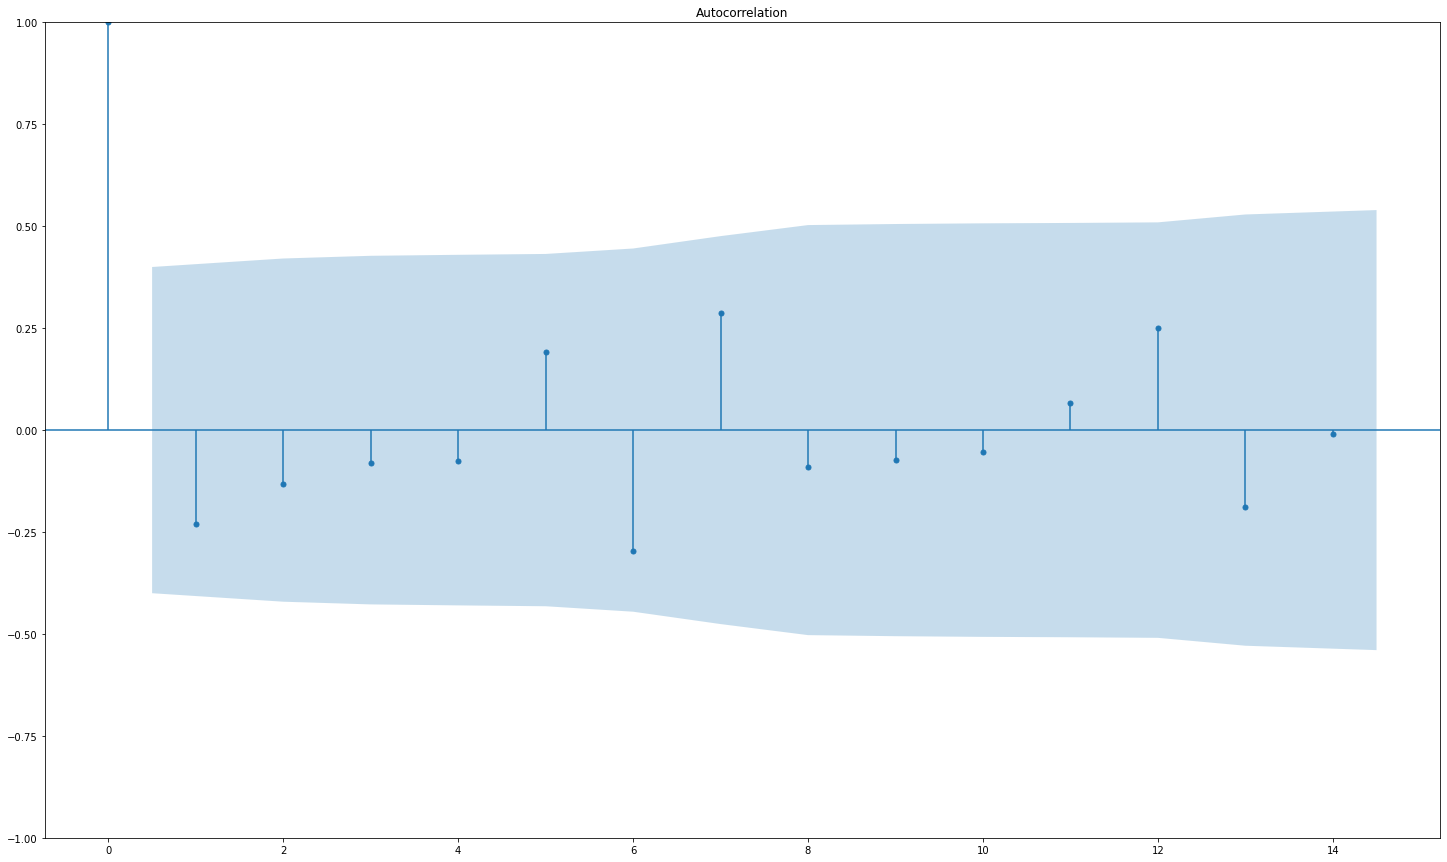

In [49]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.figure(figsize = (10,4))
plot_acf(data_diff[['TongSanLuong']])
plt.show()

c:\Users\quypr\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


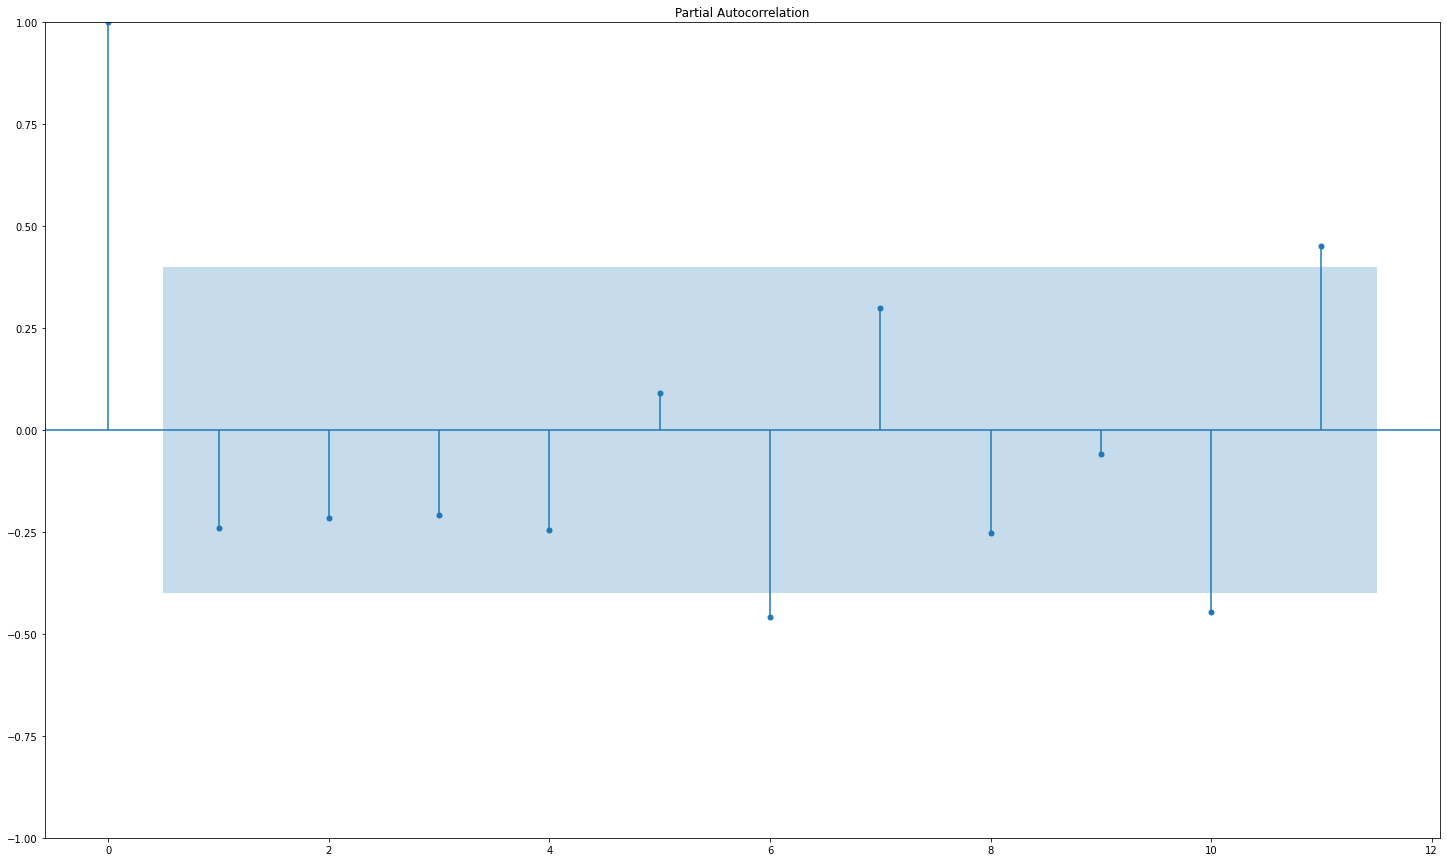

In [50]:
plot_pacf(data_diff[['TongSanLuong']],lags = 11)
plt.show()


In [51]:
arima = ARIMA(train[['TongSanLuong']],order  = (1,0,1))
res = arima.fit()

In [52]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:           TongSanLuong   No. Observations:                   19
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -111.657
Date:                Sun, 17 Jul 2022   AIC                            231.314
Time:                        20:54:22   BIC                            235.092
Sample:                    12-31-1997   HQIC                           231.954
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1519      9.127      1.112      0.266      -7.738      28.041
ar.L1          0.1389      0.530      0.262      0.793      -0.901       1.178
ma.L1         -0.6676      0.341     -1.956      0.0

In [53]:
arima_pred = res.forecast(5)

In [54]:
df_forecast_arima = pd.DataFrame(arima_pred).rename({"predicted_mean":"TongSanLuong"},axis = 1)

In [55]:
df_forecast_arima['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_arima['TongSanLuong']).cumsum()).cumsum()

In [56]:
df_forecast_arima

,TongSanLuong
2016-12-31,6632.747204
2017-12-31,6948.069952
2018-12-31,7274.325553
2019-12-31,7610.841494
2020-12-31,7957.524382


In [57]:
data_test = data[(data.index >= "2016-12-31") & (data.index <= "2020-12-31")]

In [58]:
uni_rmse = np.sqrt(mean_squared_error(data_test['TongSanLuong'],df_forecast_arima['TongSanLuong']))
uni_mae = mean_absolute_error(data_test['TongSanLuong'],df_forecast_arima['TongSanLuong'])
uni_mape = mean_absolute_percentage_error(data_test['TongSanLuong'],df_forecast_arima['TongSanLuong'])

In [59]:
df_uni = pd.DataFrame({"ARIMA":[uni_rmse,uni_mae,uni_mape]},index = ["RMSE","MAE","MAPE"])
df_uni

,ARIMA
RMSE,481.849093
MAE,459.418283
MAPE,0.058302


Text(0, 0.5, 'TongSanLuong')

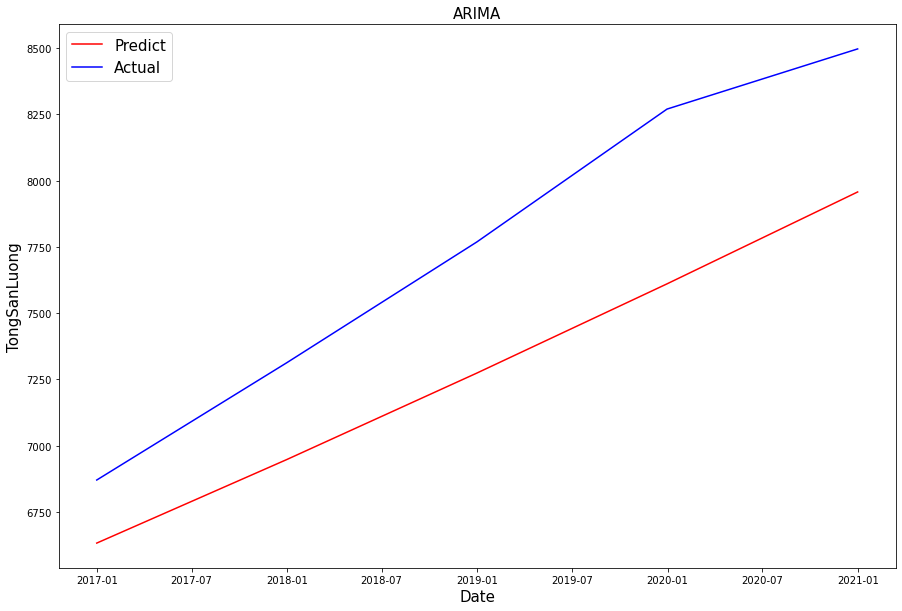

In [60]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_arima.index.date,df_forecast_arima['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test.index.date,data_test['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("ARIMA",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

# Mô hình chuỗi thời gian đa biến


## VAR

### VAR không có yếu tố ChiSoPhatTrien

In [61]:
for i in [k for k in range(1,4)]:
    var_nopt = VAR(endog = train_pt.values,dates = train_pt.index)
    var_results_nopt = var_nopt.fit(maxlags = i)
    print('Order =', i)
    print('AIC: ', var_results_nopt.aic)
    print('BIC: ', var_results_nopt.bic)
    print()


Order = 1
AIC:  29.120759599179838
BIC:  29.714340771110614

Order = 2
AIC:  28.702121708178367
BIC:  29.73138525083605

Order = 3
AIC:  27.82311292102061
BIC:  29.2717167752202



In [62]:
var_nopt_results = var_nopt.fit(3)
var_nopt_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Jul, 2022
Time:                     20:54:23
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    29.2717
Nobs:                     16.0000    HQIC:                   27.8973
Log likelihood:          -260.694    FPE:                2.31892e+12
AIC:                      27.8231    Det(Omega_mle):     5.40414e+11
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         1.202682         0.425738            2.825           0.005
L1.y1         0.363814         0.198391            1.834           0.067
L1.y2        -0.000175         0.000035           -5.042           0.000
L1.y3         0.000134

In [63]:
t = test.values[:5,1:]

In [64]:
var_nopt_pred = var_nopt_results.forecast(y = t,steps = 5)

In [65]:
var_nopt_pred = var_nopt_pred[:,-1]

In [66]:
idx = pd.date_range('2016-12-31', periods=5, freq='Y')
df_forecast_var_nopt=pd.DataFrame(data=var_nopt_pred, index=idx, columns=['TongSanLuong'])


In [67]:
df_forecast_var_nopt['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_var_nopt['TongSanLuong']).cumsum()).cumsum()

In [68]:
data_test = data[(data.index >= "2016-12-31") & (data.index <= "2020-12-31")]

In [69]:
var_nopt_rmse = np.sqrt(mean_squared_error(data_test['TongSanLuong'],df_forecast_var_nopt['TongSanLuong']))
var_nopt_mae = (mean_absolute_error(data_test['TongSanLuong'],df_forecast_var_nopt['TongSanLuong']))
var_nopt_mape= (mean_absolute_percentage_error(data_test['TongSanLuong'],df_forecast_var_nopt['TongSanLuong']))

In [70]:
pd.DataFrame({"Var no pt":[var_nopt_rmse,var_nopt_mae,var_nopt_mape]},index = ["RMSE","MAE","MAPE"])

,Var no pt
RMSE,152.250397
MAE,136.382089
MAPE,0.018074


In [ ]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_var_nopt.index.date,df_forecast_var_nopt['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test.index.date,data_test['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("VAR_NOPT",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### VAR có yếu tố ChiSoPhatTrien

In [72]:
for i in [k for k in range(1,3)]:
    var = VAR(endog = train.values,dates = train.index)
    var_results = var.fit(maxlags = i)
    print('Order =', i)
    print('AIC: ', var_results.aic)
    print('BIC: ', var_results.bic)
    print()


Order = 1
AIC:  29.850906409204732
BIC:  30.840208362422693

Order = 2
AIC:  28.165314670203152
BIC:  29.929766457616317



In [73]:
var_results = var.fit(1)
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Jul, 2022
Time:                     20:54:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    30.8402
Nobs:                     18.0000    HQIC:                   29.9873
Log likelihood:          -350.822    FPE:                9.77514e+12
AIC:                      29.8509    Det(Omega_mle):     3.66692e+12
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.089624         1.091432            0.082           0.935
L1.y1         0.822443         0.535604            1.536           0.125
L1.y2         0.325181         0.387983            0.838           0.402
L1.y3        -0.000137

Dự đoán dựa vào dữ liệu 5 năm trước

In [74]:
t = test.values

In [75]:
var_pred = var_results.forecast(y = t,steps = 5)

In [76]:
var_pred = var_pred[:,-1]

In [77]:
idx = pd.date_range('2016-12-31', periods=5, freq='Y')
df_forecast_var=pd.DataFrame(data=var_pred, index=idx, columns=['TongSanLuong'])


In [78]:
df_forecast_var['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_var['TongSanLuong']).cumsum()).cumsum()

In [79]:
df_forecast_var

,TongSanLuong
2016-12-31,6796.022565
2017-12-31,7228.922719
2018-12-31,7686.842076
2019-12-31,8145.147051
2020-12-31,8618.514151


In [80]:
data_test = data[(data.index >= "2016-12-31") & (data.index <= "2020-12-31")]

In [81]:
var_rmse = np.sqrt(mean_squared_error(data_test['TongSanLuong'],df_forecast_var['TongSanLuong']))
var_mae = mean_absolute_error(data_test['TongSanLuong'],df_forecast_var['TongSanLuong'])
var_mape = mean_absolute_percentage_error(data_test['TongSanLuong'],df_forecast_var['TongSanLuong'])

Text(0, 0.5, 'TongSanLuong')

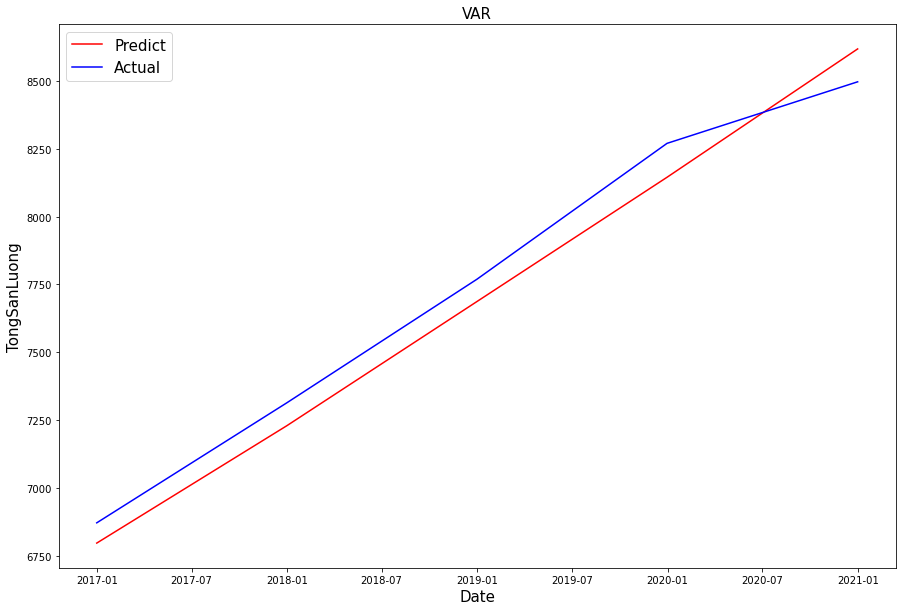

In [82]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_var.index.date,df_forecast_var['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test.index.date,data_test['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("VAR",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### So sánh kết quả giữa việc sử dụng yếu tố ChiSoPhatTrien của mô hình VAR

In [83]:
df_var = pd.DataFrame({"Var no pt":[var_nopt_rmse,var_nopt_mae,var_nopt_mape],"Var has pt":[var_rmse,var_mae,var_mape]},index = ["RMSE","MAE","MAPE"])
df_var

,Var no pt,Var has pt
RMSE,152.250397,99.834723
MAE,136.382089,97.555948
MAPE,0.018074,0.012481


## ARIMAX for multivariate

### ARIMAX không có yếu tố ChiSoPhatTrien

In [84]:
atarima_nopt = auto_arima(train_pt[['TongSanLuong']],start_p=1,start_q=1,max_p=3,max_q=3,d=0,
                trace = True,alpha = 0.05,stepwise=False,exogenous = train_pt.iloc[:,:-1], 
                error_action='ignore',  
                suppress_warnings=True,)
atarima_result_nopt = atarima_nopt.fit(train_pt[['TongSanLuong']])


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=235.715, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=231.452, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=227.824, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=235.264, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=232.996, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=233.539, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=232.516, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=234.787, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=232.418, Time=0.27 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=234.041, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=234.910, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,0,2)(0,0,0)[1] inte

In [85]:
atarima_nopt_pred = atarima_result_nopt.predict(5)

In [86]:
atarima_nopt_pred

array([48.56202771, 20.0682447 , 10.0913409 , 10.0913409 , 10.0913409 ])

In [87]:
idx = pd.date_range('2016-12-31', periods=5, freq='Y')
df_forecast_atarima_nopt=pd.DataFrame(data=atarima_nopt_pred, index=idx, columns=['TongSanLuong'])


In [88]:
df_forecast_atarima_nopt['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_atarima_nopt['TongSanLuong']).cumsum()).cumsum()

In [89]:
atarima_nopt_rmse = np.sqrt(mean_squared_error(data_test['TongSanLuong'],df_forecast_atarima_nopt['TongSanLuong']))
atarima_nopt_mae = (mean_absolute_error(data_test['TongSanLuong'],df_forecast_atarima_nopt['TongSanLuong']))
atarima_nopt_mape = (mean_absolute_percentage_error(data_test['TongSanLuong'],df_forecast_atarima_nopt['TongSanLuong']))

In [90]:
pd.DataFrame({"AUTOARIMA no pt":[atarima_nopt_rmse,atarima_nopt_mae,atarima_nopt_mape]},index = ["RMSE","MAE","MAPE"])

,AUTOARIMA no pt
RMSE,480.146034
MAE,458.214746
MAPE,0.058167


Text(0, 0.5, 'TongSanLuong')

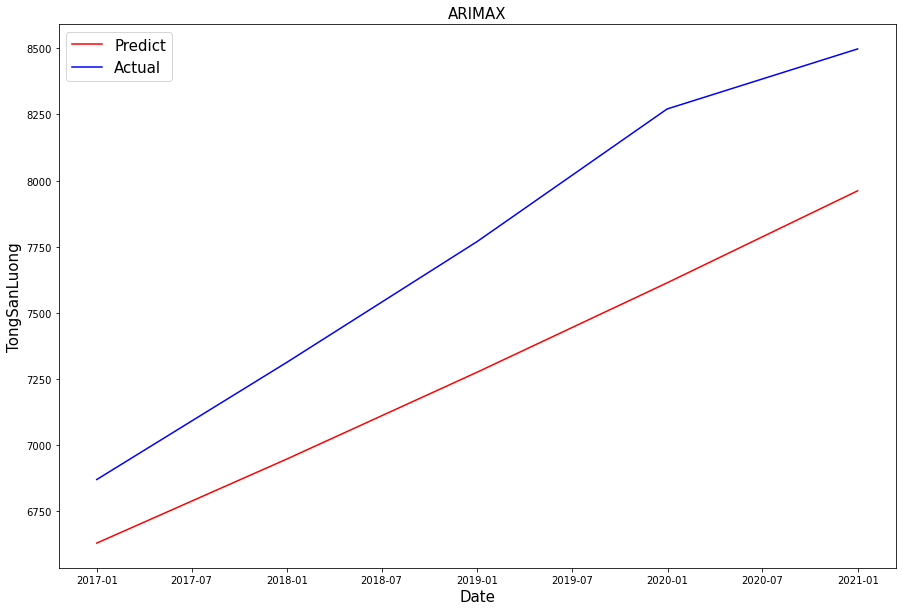

In [91]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_atarima_nopt.index.date,df_forecast_atarima_nopt['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test.index.date,data_test['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("ARIMAX",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### ARIMAX có yếu tố ChiSoPhatTrien

In [92]:
atarima = auto_arima(train[['TongSanLuong']],start_p=1,start_q=1,max_p=3,max_q=3,d=0,
                trace = True,alpha = 0.05,stepwise=False,exogenous = train.iloc[:,:-1], 
                error_action='ignore',  
                suppress_warnings=True,)
atarima_result = atarima.fit(train[['TongSanLuong']])


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=203.299, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=199.819, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=203.319, Time=0.20 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=214.810, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=203.332, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=202.100, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=211.867, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=204.717, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=207.365, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=209.667, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=205.349, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=207.845, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=208.445, Time=0.26 sec

Best model:  ARIMA(0,0,1)(0,0,0)

In [93]:
atarima_pred = atarima_result.predict(5)

In [94]:
idx = pd.date_range('2016-12-31', periods=5, freq='Y')
df_forecast_atarima=pd.DataFrame(data=atarima_pred, index=idx, columns=['TongSanLuong'])


In [95]:
df_forecast_atarima

,TongSanLuong
2016-12-31,48.366308
2017-12-31,10.207793
2018-12-31,10.207793
2019-12-31,10.207793
2020-12-31,10.207793


In [96]:
df_forecast_atarima['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_atarima['TongSanLuong']).cumsum()).cumsum()

In [97]:
df_forecast_atarima

,TongSanLuong
2016-12-31,6630.466308
2017-12-31,6937.940410
2018-12-31,7255.622305
2019-12-31,7583.511994
2020-12-31,7921.609476


In [98]:
atarima_rmse = np.sqrt(mean_squared_error(data_test['TongSanLuong'],df_forecast_atarima['TongSanLuong']))
atarima_mae = mean_absolute_error(data_test['TongSanLuong'],df_forecast_atarima['TongSanLuong'])
atarima_mape = mean_absolute_percentage_error(data_test['TongSanLuong'],df_forecast_atarima['TongSanLuong'])

Text(0, 0.5, 'TongSanLuong')

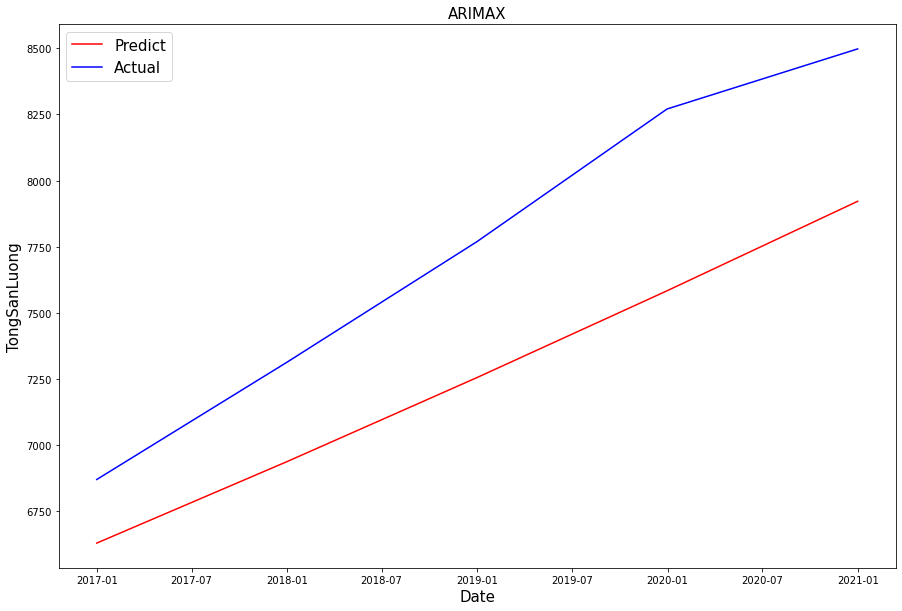

In [99]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_atarima.index.date,df_forecast_atarima['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test.index.date,data_test['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("ARIMAX",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### So sánh kết quả giữa việc sử dụng yếu tố ChiSoPhatTrien của mô hình AUTOARIMA

In [100]:
df_atarima =pd.DataFrame({"AUTOARIMA no pt":[atarima_nopt_rmse,atarima_nopt_mae,atarima_nopt_mape],"AUTOARIMA has pt":[atarima_rmse,atarima_mae,atarima_mape]},index = ["RMSE","MAE","MAPE"])
df_atarima

,AUTOARIMA no pt,AUTOARIMA has pt
RMSE,480.146034,503.028099
MAE,458.214746,478.289901
MAPE,0.058167,0.060633


## LSTM

In [101]:
data_test_lstm = data[(data.index >= "2016-12-31") & (data.index <= "2020-12-31")]

In [102]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000
TRAIN_SPLIT = 16

# LSTM Parameters
EVALUATION_INTERVAL = 100
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)


In [103]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    print(start_index,end_index)
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

### LSTM không có yếu tố ChiSoPhatTrien

In [104]:
data_lstm_nopt = data_diff.iloc[:,1:]

In [105]:
data_lstm_nopt

,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
Nam,,,
1997-12-31,1.754411,-26200.000000,-87.2
1998-12-31,2.732394,299.000000,22.2
1999-12-31,0.464159,1598.000000,173.2
2000-12-31,4.895150,6371.000000,19.3
2001-12-31,4.838863,-790.000000,-59.9
2002-12-31,3.489766,2822.000000,28.6
2003-12-31,4.119322,1322.000000,-0.9
2004-12-31,3.744436,2308.000000,71.5
2005-12-31,3.191252,5450.000000,40.2


In [106]:
past_history = 3
future_target = 5
STEP = 1

x_train_multi_nopt, y_train_multi_nopt = multivariate_data(data_lstm_nopt.values[:,:-1], data_lstm_nopt.values[:, -1], 0,
                                                 20, past_history,
                                                 future_target, STEP)
x_val_multi_nopt, y_val_multi_nopt = multivariate_data(data_lstm_nopt.values[:,:-1], data_lstm_nopt.values[:, -1],
                                             15, None, past_history,
                                             future_target, STEP)

3 20
18 19


In [107]:
train_data_multi_nopt = tf.data.Dataset.from_tensor_slices((x_train_multi_nopt, y_train_multi_nopt))
train_data_multi_nopt = train_data_multi_nopt.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_nopt = tf.data.Dataset.from_tensor_slices((x_val_multi_nopt, y_val_multi_nopt))
val_data_multi_nopt = val_data_multi_nopt.batch(BATCH_SIZE).repeat()


In [108]:
multi_step_model_nopt = tf.keras.models.Sequential()
multi_step_model_nopt.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi_nopt.shape[-2:]))
multi_step_model_nopt.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model_nopt.add(Dense(64,activation='relu'))

multi_step_model_nopt.add(tf.keras.layers.Dense(5,activation = 'relu'))

multi_step_model_nopt.compile(optimizer=tf.keras.optimizers.Adam(), metrics = 'mae',loss = 'mae')
print(multi_step_model_nopt.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             17152     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 54,661
Trainable params: 54,661
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
multi_step_history = multi_step_model_nopt.fit(train_data_multi_nopt,
                                          epochs=120,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi_nopt,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])


Epoch 1/120
100/100 [==============================] - 3s 11ms/step - loss: 76.7922 - mae: 76.7922 - val_loss: 58.2342 - val_mae: 58.2342
Epoch 2/120
100/100 [==============================] - 0s 5ms/step - loss: 68.1427 - mae: 68.1427 - val_loss: 49.7739 - val_mae: 49.7739
Epoch 3/120
100/100 [==============================] - 0s 4ms/step - loss: 65.6963 - mae: 65.6963 - val_loss: 49.3644 - val_mae: 49.3644
Epoch 4/120
100/100 [==============================] - 0s 5ms/step - loss: 63.8424 - mae: 63.8424 - val_loss: 48.1041 - val_mae: 48.1041
Epoch 5/120
100/100 [==============================] - 0s 4ms/step - loss: 61.7750 - mae: 61.7750 - val_loss: 32.6951 - val_mae: 32.6951
Epoch 6/120
100/100 [==============================] - 0s 4ms/step - loss: 58.6155 - mae: 58.6155 - val_loss: 14.4661 - val_mae: 14.4661
Epoch 7/120
100/100 [==============================] - 0s 4ms/step - loss: 54.3662 - mae: 54.3662 - val_loss: 13.8206 - val_mae: 13.8206
Epoch 8/120
100/100 [===================

In [110]:
pred = []
for x, y in val_data_multi_nopt.take(1):
    pred.append(multi_step_model_nopt.predict(x)[0])
pred[0]

1/1 [==============================] - 0s 444ms/step


array([  0.      ,  39.74439 , 154.53223 ,  13.184461,  45.75136 ],
      dtype=float32)

In [111]:
idx = pd.date_range('2016-12-31', periods=5, freq='Y')
df_forecast_lstm_nopt=pd.DataFrame(data=pred[0], index=idx, columns=['TongSanLuong'])


In [112]:
df_forecast_lstm_nopt

,TongSanLuong
2016-12-31,0.000000
2017-12-31,39.744389
2018-12-31,154.532227
2019-12-31,13.184461
2020-12-31,45.751362


In [113]:
df_forecast_lstm_nopt['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_lstm_nopt['TongSanLuong']).cumsum()).cumsum()

In [114]:
df_forecast_lstm_nopt

,TongSanLuong
2016-12-31,6582.100098
2017-12-31,6870.744629
2018-12-31,7313.920898
2019-12-31,7770.282227
2020-12-31,8272.394531


In [115]:
lstm_nopt_rmse = np.sqrt(mean_squared_error(data_test_lstm['TongSanLuong'],df_forecast_lstm_nopt['TongSanLuong']))
lstm_nopt_mae = (mean_absolute_error(data_test_lstm['TongSanLuong'],df_forecast_lstm_nopt['TongSanLuong']))
lstm_nopt_mape = (mean_absolute_percentage_error(data_test_lstm['TongSanLuong'],df_forecast_lstm_nopt['TongSanLuong']))

In [116]:
pd.DataFrame({"LSTM no pt":[lstm_nopt_rmse,lstm_nopt_mae,lstm_nopt_mape]},index = ["RMSE","MAE","MAPE"])

,LSTM no pt
RMSE,396.705678
MAE,382.231523
MAPE,0.049605


Text(0, 0.5, 'TongSanLuong')

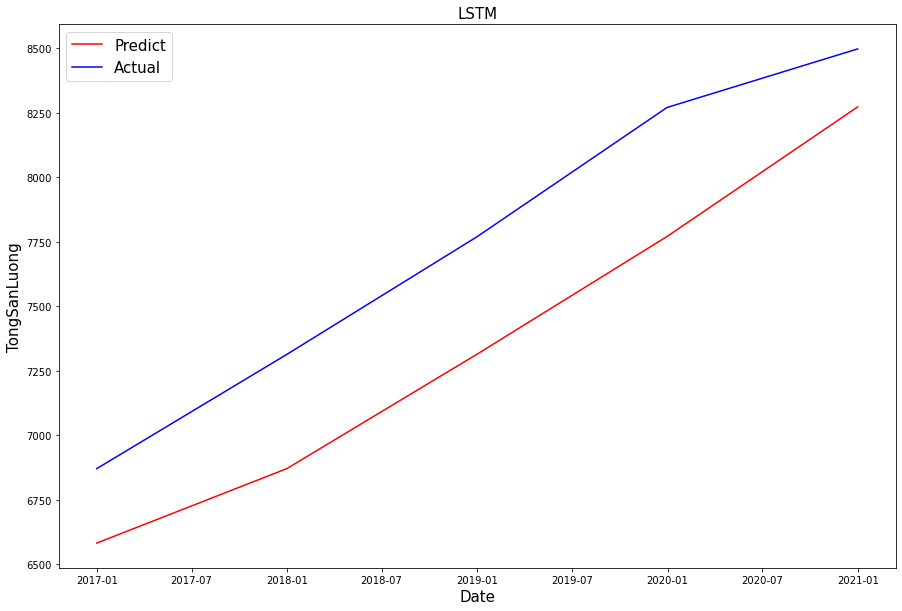

In [117]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_lstm_nopt.index.date,df_forecast_lstm_nopt['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test_lstm.index.date,data_test_lstm['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("LSTM",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### LSTM có yếu tố ChiSoPhatTrien

In [118]:
data_lstm = data_diff

In [119]:
data_lstm

,ChiSoPhatTrien,DienTichNuoiTrong,SoTauKhaiThacBien,TongSanLuong
Nam,,,,
1997-12-31,-5.7,1.754411,-26200.000000,-87.2
1998-12-31,1.3,2.732394,299.000000,22.2
1999-12-31,9.6,0.464159,1598.000000,173.2
2000-12-31,-0.5,4.895150,6371.000000,19.3
2001-12-31,-3.9,4.838863,-790.000000,-59.9
2002-12-31,0.5,3.489766,2822.000000,28.6
2003-12-31,-0.7,4.119322,1322.000000,-0.9
2004-12-31,1.9,3.744436,2308.000000,71.5
2005-12-31,0.4,3.191252,5450.000000,40.2


In [120]:
past_history = 3
future_target = 5
STEP = 1

x_train_multi, y_train_multi = multivariate_data(data_lstm.values[:,:-1], data_lstm.values[:, -1], 0,
                                                 20, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(data_lstm.values[:,:-1], data_lstm.values[:, -1],
                                             15, None, past_history,
                                             future_target, STEP)

3 20
18 19


In [121]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [122]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(Dense(64,activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5,activation = 'relu'))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), metrics = 'mae',loss = 'mae')
print(multi_step_model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 54,917
Trainable params: 54,917
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=120,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])


Epoch 1/120
100/100 [==============================] - 3s 9ms/step - loss: 77.6500 - mae: 77.6500 - val_loss: 54.1397 - val_mae: 54.1397
Epoch 2/120
100/100 [==============================] - 0s 5ms/step - loss: 72.2409 - mae: 72.2409 - val_loss: 55.2034 - val_mae: 55.2034
Epoch 3/120
100/100 [==============================] - 0s 4ms/step - loss: 70.4232 - mae: 70.4232 - val_loss: 55.0370 - val_mae: 55.0370
Epoch 4/120
100/100 [==============================] - 0s 4ms/step - loss: 68.2643 - mae: 68.2643 - val_loss: 53.8944 - val_mae: 53.8944
Epoch 5/120
100/100 [==============================] - 0s 4ms/step - loss: 60.2152 - mae: 60.2152 - val_loss: 43.2923 - val_mae: 43.2923
Epoch 6/120
100/100 [==============================] - 0s 4ms/step - loss: 52.4678 - mae: 52.4678 - val_loss: 25.1218 - val_mae: 25.1218
Epoch 7/120
100/100 [==============================] - 0s 4ms/step - loss: 50.3880 - mae: 50.3880 - val_loss: 24.7789 - val_mae: 24.7789
Epoch 8/120
100/100 [====================

In [124]:
pred = []
for x, y in val_data_multi.take(1):
    pred.append(multi_step_model.predict(x)[0])
pred[0]

1/1 [==============================] - 0s 412ms/step


array([  0.      ,  39.647976, 154.70232 ,   0.      ,   0.      ],
      dtype=float32)

In [125]:
idx = pd.date_range('2016-12-31', periods=5, freq='Y')
df_forecast_lstm=pd.DataFrame(data=pred[0], index=idx, columns=['TongSanLuong'])


In [126]:
df_forecast_lstm

,TongSanLuong
2016-12-31,0.000000
2017-12-31,39.647976
2018-12-31,154.702316
2019-12-31,0.000000
2020-12-31,0.000000


In [127]:
df_forecast_lstm['TongSanLuong'] = data_1 + ((data_first_diff) + (df_forecast_lstm['TongSanLuong']).cumsum()).cumsum()

In [128]:
lstm_rmse = np.sqrt(mean_squared_error(data_test_lstm['TongSanLuong'],df_forecast_lstm['TongSanLuong']))
lstm_mae = mean_absolute_error(data_test_lstm['TongSanLuong'],df_forecast_lstm['TongSanLuong'])
lstm_mape = mean_absolute_percentage_error(data_test_lstm['TongSanLuong'],df_forecast_lstm['TongSanLuong'])

Text(0, 0.5, 'TongSanLuong')

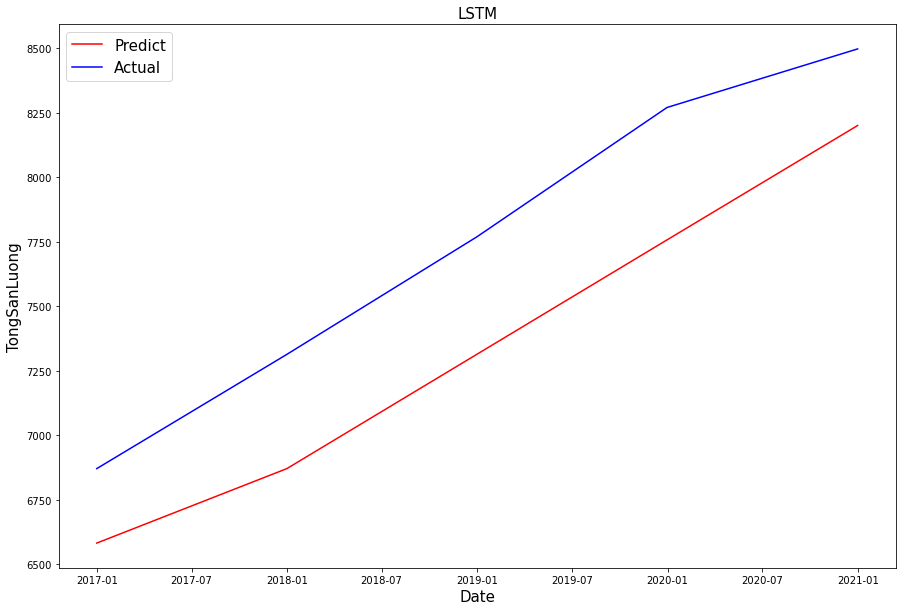

In [129]:
plt.figure(figsize=(15,10))
plt.plot(df_forecast_lstm.index.date,df_forecast_lstm['TongSanLuong'],'r-',label = "Predict")
plt.plot(data_test_lstm.index.date,data_test_lstm['TongSanLuong'],'b-',label = "Actual")
plt.legend(fontsize = 15)
plt.title("LSTM",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.ylabel("TongSanLuong",fontsize = 15)

### So sánh kết quả giữa việc sử dụng yếu tố ChiSoPhatTrien của mô hình LSTM

In [130]:
df_lstm = pd.DataFrame({"LSTM no pt":[lstm_nopt_rmse,lstm_nopt_mae,lstm_nopt_mape],"LSTM has pt":[lstm_rmse,lstm_mae,lstm_mape]},index = ["RMSE","MAE","MAPE"])
df_lstm

,LSTM no pt,LSTM has pt
RMSE,396.705678,409.350536
MAE,382.231523,399.280938
MAPE,0.049605,0.051620


# Kết quả các mô hình

## ARIMA

In [131]:
df_uni

,ARIMA
RMSE,481.849093
MAE,459.418283
MAPE,0.058302


## VAR

In [132]:
df_var

,Var no pt,Var has pt
RMSE,152.250397,99.834723
MAE,136.382089,97.555948
MAPE,0.018074,0.012481


## AUTO ARIMA

In [133]:
df_atarima

,AUTOARIMA no pt,AUTOARIMA has pt
RMSE,480.146034,503.028099
MAE,458.214746,478.289901
MAPE,0.058167,0.060633


## LSTM

In [134]:
df_lstm

,LSTM no pt,LSTM has pt
RMSE,396.705678,409.350536
MAE,382.231523,399.280938
MAPE,0.049605,0.051620
